#### Progetto di corso per APPLICAZIONI DELL'INTELLIGENZA ARTIFICIALE (AA 2024-2025)
#### Stud: Marzio Della Bosca


Questo notebook si occupa di addestrate e valutare diverse architetture di reti neurali sui dati processati e salvati nei Notebook precedenti.

In [23]:
import warnings
warnings.filterwarnings("ignore")
from tqdm import tqdm
import time
import os

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
from collections import Counter

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.metrics import accuracy_score, confusion_matrix

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [2]:
print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("CUDA device name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU found")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

PyTorch version: 2.5.1+cu121
CUDA available: True
CUDA device name: NVIDIA GeForce RTX 3050
Device: cuda


In [ ]:
class SimpleMLP(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(SimpleMLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, num_classes)
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class SimpleCNN(nn.Module):
    def __init__(self, input_channels, sequence_length, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv1d(input_channels, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()  # Definito una volta nel costruttore
        
        # Calcola la dimensione dell'output dopo convoluzioni e pooling
        self.flattened_size = 64 * (sequence_length // 2)  # Dopo un MaxPool1d con kernel_size=2
        
        self.fc1 = nn.Linear(self.flattened_size, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)  # Flatten per il livello fully connected
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

def train_model(model, train_loader, val_loader, criterion, optimizer, n_epoche):
    acc_vec = []
    loss_vec = []

    max_acc = -1
    min_acc = -1

    max_loss = -1
    min_loss = -1

    epoc_max_loss = -1
    epoc_min_loss = -1

    epoc_max_acc = -1
    epoc_min_acc = -1
    
    startT = time.time()

    for epoch in tqdm(range(n_epoche), desc="Training epochs.."):
        model.train()
        running_loss = 0.0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            outputs = model(xb)
            loss = criterion(outputs, yb)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * xb.size(0)
            
        epoch_loss = running_loss / len(train_loader.dataset)
        loss_vec.append(epoch_loss)

        # Valutazione
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device) 
                outputs = model(xb)
                _, predicted = torch.max(outputs, 1)
                total += yb.size(0)
                correct += (predicted == yb).sum().item()
        acc = correct / total
        acc_vec.append(acc)

        if epoch == 0:
            max_acc = acc
            min_acc = acc
            max_loss = epoch_loss
            min_loss = epoch_loss
            epoc_max_loss = 1
            epoc_min_loss = 1
            epoc_max_acc = 1
            epoc_min_acc = 1
        

        if acc > max_acc:
            max_acc = acc
            epoc_max_acc = epoch + 1

        if acc < min_acc:
            min_acc = acc
            epoc_min_acc = epoch + 1

        if epoch_loss > max_loss:
            max_loss = epoch_loss
            epoc_max_loss = epoch + 1

        if epoch_loss < min_loss:
            min_loss = epoch_loss
            epoc_min_loss = epoch + 1

    print(f"Tempo totale di addestramento: {time.time() - startT:.2f} secondi")

    all_preds = []
    all_labels = []
    timeStart = time.time()
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            outputs = model(xb)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(yb.cpu().numpy())
    print(f"Tempo di valutazione (predizioni): {time.time() - timeStart:.2f} secondi\n")

    print(f"Accuratezza finale: {acc_vec[-1]:.4f}")
    print(f"Accuratezza media: {np.mean(acc_vec):.4f}")

    print(f"Accuratezza minima: {np.min(acc_vec):.4f}, epoca: {epoc_min_acc}")
    print(f"Accuratezza massima: {np.max(acc_vec):.4f}, epoca: {epoc_max_acc}")

    print(f"Loss finale: {loss_vec[-1]:.4f}, epoca: {epoc_max_loss}")
    print(f"Loss media: {np.mean(loss_vec):.4f}")

    print(f"Loss minima: {np.min(loss_vec):.4f}, epoca: {epoc_min_loss}")
    print(f"Loss massima: {np.max(loss_vec):.4f}, epoca: {epoc_max_loss}\n")

    return acc_vec, loss_vec

def loaders_maker(data, y, batch_S, seed):

    # Converte in tensori torch il modello da addestrare su dataset catch22
    feature_t = torch.tensor(data, dtype=torch.float32)
    y_t = torch.tensor(y, dtype=torch.long)

    x_train, x_val, y_train, y_val = train_test_split(feature_t, y_t, test_size=0.2, random_state=seed)

    # Dataset e DataLoader
    train_dataset = torch.utils.data.TensorDataset(x_train, y_train)
    val_dataset = torch.utils.data.TensorDataset(x_val, y_val)

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_S, shuffle=True, pin_memory=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_S, shuffle=False, pin_memory=True)

    return train_loader, val_loader

def plot_results(acc_tsfel, acc_catch22, loss_tsfel, loss_catch22, n_epoche):
    mean_acc_tsfel = np.mean(acc_tsfel, axis=0)
    std_acc_tsfel = np.std(acc_tsfel, axis=0)
    min_acc_tsfel = np.min(acc_tsfel)  
    max_acc_tsfel = np.max(acc_tsfel) 

    mean_acc_catch22 = np.mean(acc_catch22, axis=0)
    std_acc_catch22 = np.std(acc_catch22, axis=0)
    min_acc_catch22 = np.min(acc_catch22)  
    max_acc_catch22 = np.max(acc_catch22)  

    mean_loss_tsfel = np.mean(loss_tsfel, axis=0)
    std_loss_tsfel = np.std(loss_tsfel, axis=0)
    min_loss_tsfel = np.min(loss_tsfel)  
    max_loss_tsfel = np.max(loss_tsfel)  

    mean_loss_catch22 = np.mean(loss_catch22, axis=0)
    std_loss_catch22 = np.std(loss_catch22, axis=0)
    min_loss_catch22 = np.min(loss_catch22)  
    max_loss_catch22 = np.max(loss_catch22)  

    plt.figure(figsize=(16, 8))
    # TSFEL
    plt.plot(mean_acc_tsfel, label=f"TSFEL (Media: {mean_acc_tsfel[-1]:.4f}, Min: {min_acc_tsfel:.4f}, Max: {max_acc_tsfel:.4f}, Std: {std_acc_tsfel[-1]:.4f})", color='blue')
    plt.fill_between(range(len(mean_acc_tsfel)), 
                    mean_acc_tsfel - std_acc_tsfel, 
                    mean_acc_tsfel + std_acc_tsfel, 
                    color='blue', alpha=0.3)

    # CATCH22
    plt.plot(mean_acc_catch22, label=f"CATCH22 (Media: {mean_acc_catch22[-1]:.4f}, Min: {min_acc_catch22:.4f}, Max: {max_acc_catch22:.4f}, Std: {std_acc_catch22[-1]:.4f})", color='orange')
    plt.fill_between(range(len(mean_acc_catch22)), 
                    mean_acc_catch22 - std_acc_catch22, 
                    mean_acc_catch22 + std_acc_catch22, 
                    color='orange', alpha=0.3)

    plt.title('Accuratezza Media per Epoca con Intervalli di Confidenza - seed = 64, 256, 571')
    plt.xticks(np.arange(0, n_epoche, step=10))
    plt.xlabel('Epoche')
    plt.ylabel('Accuratezza')
    plt.legend()
    plt.grid()
    plt.show()

    # Loss media con intervalli di confidenza
    plt.figure(figsize=(16, 8))
    mean_loss_tsfel = np.mean(loss_tsfel, axis=0)
    std_loss_tsfel = np.std(loss_tsfel, axis=0)
    mean_loss_catch22 = np.mean(loss_catch22, axis=0)
    std_loss_catch22 = np.std(loss_catch22, axis=0)

    # TSFEL
    plt.plot(mean_loss_tsfel, label=f"TSFEL (Media: {mean_loss_tsfel[-1]:.4f}, Min: {min_loss_tsfel:.4f}, Max: {max_loss_tsfel:.4f}, Std: {std_loss_tsfel[-1]:.4f})", color='blue')
    plt.fill_between(range(len(mean_loss_tsfel)), 
                    mean_loss_tsfel - std_loss_tsfel, 
                    mean_loss_tsfel + std_loss_tsfel, 
                    color='blue', alpha=0.3)

    # CATCH22
    plt.plot(mean_loss_catch22, label=f"CATCH22 (Media: {mean_loss_catch22[-1]:.4f}, Min: {min_loss_catch22:.4f}, Max: {max_loss_catch22:.4f}, Std: {std_loss_catch22[-1]:.4f})", color='orange')
    plt.fill_between(range(len(mean_loss_catch22)), 
                    mean_loss_catch22 - std_loss_catch22, 
                    mean_loss_catch22 + std_loss_catch22, 
                    color='orange', alpha=0.3)


    plt.title('Loss Media per Epoca con Intervalli di Confidenza - seed = 64, 256, 571')
    plt.xticks(np.arange(0, n_epoche, step=10))
    plt.xlabel('Epoche')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()



In [12]:
catch22 = np.load('catch22_uni.npy')
tsfel = np.load('tsfel_uni.npy')
y = np.load('labels_uni.npy')

print(f"Shape catch22: {catch22.shape}")
print(f"Shape tsfel: {tsfel.shape}")
print(f"Shape labels: {y.shape}")

Shape catch22: (375358, 132)
Shape tsfel: (375358, 270)
Shape labels: (375358,)


In [13]:
print(np.isnan(catch22).any(), np.isinf(catch22).any())
print(np.isnan(tsfel).any(), np.isinf(tsfel).any())

# Trova gli indici dei valori NaN in catch22
nan_indices_catch22 = np.where(np.isnan(catch22))
print("Indici dei NaN in catch22:", nan_indices_catch22)

# Trova gli indici dei valori NaN in tsfel
nan_indices_tsfel = np.where(np.isnan(tsfel))
print("Indici dei NaN in tsfel:", nan_indices_tsfel)

False False
False False
Indici dei NaN in catch22: (array([], dtype=int64), array([], dtype=int64))
Indici dei NaN in tsfel: (array([], dtype=int64), array([], dtype=int64))


In [ ]:
# Controlla la distribuzione originale delle classi
print("Distribuzione originale delle classi:", Counter(y))

# Trova la classe con il numero minimo di esempi
min_class_count = min(Counter(y).values())

# Indici bilanciati con selezione casuale
balanced_indices = []
np.random.seed(42)  # Per riproducibilità
for label in np.unique(y):
    label_indices = np.where(y == label)[0]
    # Seleziona casualmente 'min_class_count' indici per ogni classe
    selected_indices = np.random.choice(label_indices, min_class_count, replace=False)
    balanced_indices.extend(selected_indices)

# Shuffle finale degli indici bilanciati
np.random.shuffle(balanced_indices)

# Applica gli indici bilanciati ai dataset
catch22_bal = catch22[balanced_indices]
tsfel_bal = tsfel[balanced_indices]
y_bal = y[balanced_indices]

# Controlla la nuova distribuzione delle classi
print("Distribuzione bilanciata delle classi:", Counter(y_bal))
print(f"Shape catch22_balanced: {catch22_bal.shape}")
print(f"Shape tsfel_balanced: {tsfel_bal.shape}")
print(f"Shape labels_balanced: {y_bal.shape}")

In [ ]:
lr = 1e-4
seed = 42
criterion = nn.CrossEntropyLoss()


model_tsfel_bal = SimpleMLP(input_dim=tsfel_bal.shape[1], num_classes=6)
model_catch22_bal = SimpleMLP(input_dim=catch22_bal.shape[1], num_classes=6)

model_tsfel = SimpleMLP(input_dim=tsfel.shape[1], num_classes=6)
model_catch22 = SimpleMLP(input_dim=catch22.shape[1], num_classes=6)

optimizer_catch22_bal = optim.Adam(model_catch22_bal.parameters(), lr=lr)
optimizer_tsfel_bal = optim.Adam(model_tsfel_bal.parameters(), lr=lr)

optimizer_catch22 = optim.Adam(model_catch22.parameters(), lr=lr)
optimizer_tsfel = optim.Adam(model_tsfel.parameters(), lr=lr)

batch_size = 1024

# Confronto Accuracy per dati sbilanciati e bilanciati
train_loader_tsfel_bal, val_loader_tsfel_bal = loaders_maker(tsfel_bal, y_bal, batch_size, seed) # bilanciati

startT = time.time()
acc_vec_tsfel, loss_vec_tsfel = train_model(model_tsfel_bal.to(device), train_loader_tsfel_bal, val_loader_tsfel_bal, criterion, optimizer_tsfel_bal, 100)
print(f"Tempo di esecuzione TSFEL bilanciato: {time.time() - startT:.2f} secondi\n")

train_loader_catch22_bal, val_loader_catch22_bal = loaders_maker(catch22_bal, y_bal, batch_size, seed)

startT = time.time()
acc_vec_catch22, loss_vec_catch22 = train_model(model_catch22_bal.to(device), train_loader_catch22_bal, val_loader_catch22_bal, criterion, optimizer_catch22_bal, 100)
print(f"\nTempo di esecuzione CATCH22 bilanciato: {time.time() - startT:.2f} secondi\n")

train_loader_tsfel, val_loader_tsfel = loaders_maker(tsfel, y, batch_size, seed) # sbilanciati

startT = time.time()
acc_vec_tsfel, loss_vec_tsfel = train_model(model_tsfel.to(device), train_loader_tsfel, val_loader_tsfel, criterion, optimizer_tsfel, 100)
print(f"\nTempo di esecuzione TSFEL sbilanciato: {time.time() - startT:.2f} secondi\n")

train_loader_catch22, val_loader_catch22 = loaders_maker(catch22, y, batch_size, seed)

startT = time.time()
acc_vec_catch22, loss_vec_catch22 = train_model(model_catch22.to(device), train_loader_catch22, val_loader_catch22, criterion, optimizer_catch22, 100)
print(f"\nTempo di esecuzione CATCH22 sbilanciato: {time.time() - startT:.2f} secondi\n")

Training epochs..: 100%|██████████| 100/100 [03:46<00:00,  2.26s/it]


Tempo totale di addestramento: 226.23 secondi
Tempo di valutazione (predizioni): 0.36 secondi

Accuratezza finale: 0.8898
Accuratezza media: 0.8627
Accuratezza minima: 0.6267, epoca: 1
Accuratezza massima: 0.8898, epoca: 100
Loss finale: 0.2589, epoca: 1
Loss media: 0.3594
Loss minima: 0.2589, epoca: 100
Loss massima: 1.3761, epoca: 1

Tempo di esecuzione TSFEL bilanciato: 226.59 secondi



Training epochs..: 100%|██████████| 100/100 [03:34<00:00,  2.15s/it]


Tempo totale di addestramento: 214.72 secondi
Tempo di valutazione (predizioni): 0.56 secondi

Accuratezza finale: 0.8278
Accuratezza media: 0.7904
Accuratezza minima: 0.5518, epoca: 1
Accuratezza massima: 0.8278, epoca: 100
Loss finale: 0.4082, epoca: 1
Loss media: 0.5378
Loss minima: 0.4082, epoca: 100
Loss massima: 1.4822, epoca: 1


Tempo di esecuzione CATCH22 bilanciato: 215.28 secondi



Training epochs..: 100%|██████████| 100/100 [07:09<00:00,  4.29s/it]


Tempo totale di addestramento: 429.14 secondi
Tempo di valutazione (predizioni): 0.85 secondi

Accuratezza finale: 0.9272
Accuratezza media: 0.9111
Accuratezza minima: 0.7628, epoca: 1
Accuratezza massima: 0.9274, epoca: 93
Loss finale: 0.1870, epoca: 1
Loss media: 0.2571
Loss minima: 0.1870, epoca: 100
Loss massima: 1.0551, epoca: 1


Tempo di esecuzione TSFEL sbilanciato: 430.00 secondi



Training epochs..: 100%|██████████| 100/100 [06:27<00:00,  3.87s/it]


Tempo totale di addestramento: 387.01 secondi
Tempo di valutazione (predizioni): 0.65 secondi

Accuratezza finale: 0.8825
Accuratezza media: 0.8593
Accuratezza minima: 0.6941, epoca: 1
Accuratezza massima: 0.8826, epoca: 96
Loss finale: 0.3020, epoca: 1
Loss media: 0.3954
Loss minima: 0.3020, epoca: 100
Loss massima: 1.2095, epoca: 1


Tempo di esecuzione CATCH22 sbilanciato: 387.66 secondi



In [ ]:
# Test sugli mlp
# 0-Walking, 1-Jogging, 2-DownStairs, 3-UpStairs, 4-Sitting, 5-Standing
n_epoche = 100
seeds = [64, 256, 571]
batch_size = 1024
criterion = nn.CrossEntropyLoss()
lr = 1e-4

acc_tsfel = []
acc_catch22 = []

loss_tsfel = []
loss_catch22 = []

execution_tsfel_times = []
execution_catch22_times = []

for seed in seeds:
    print(f"Seed: {seed}")
    
    model_tsfel = SimpleMLP(input_dim=tsfel.shape[1], num_classes=6)
    model_catch22 = SimpleMLP(input_dim=catch22.shape[1], num_classes=6)

    train_loader_tsfel, val_loader_tsfel = loaders_maker(tsfel, y, batch_size, seed)
    optimizer = optim.Adam(model_tsfel.parameters(), lr=lr)

    startT = time.time()
    acc_vec_tsfel, loss_vec_tsfel = train_model(model_tsfel.to(device), train_loader_tsfel, val_loader_tsfel, criterion, optimizer, n_epoche)
    execution_tsfel_times.append(time.time() - startT)

    acc_tsfel.append(acc_vec_tsfel)
    loss_tsfel.append(loss_vec_tsfel)

    train_loader_catch22, val_loader_catch22 = loaders_maker(catch22, y, batch_size, seed)
    optimizer = optim.Adam(model_catch22.parameters(), lr=lr)

    startT = time.time()
    acc_vec_catch22, loss_vec_catch22 = train_model(model_catch22.to(device), train_loader_catch22, val_loader_catch22, criterion, optimizer, n_epoche)
    execution_catch22_times.append(time.time() - startT)
    
    acc_catch22.append(acc_vec_catch22)
    loss_catch22.append(loss_vec_catch22)


Seed: 64


Training epochs..: 100%|██████████| 100/100 [07:00<00:00,  4.21s/it]


Tempo totale di addestramento: 420.77 secondi
Tempo di valutazione (predizioni): 0.56 secondi

Accuratezza finale: 0.9256
Accuratezza media: 0.9096
Accuratezza minima: 0.7617, epoca: 1
Accuratezza massima: 0.9257, epoca: 99
Loss finale: 0.1875, epoca: 1
Loss media: 0.2585
Loss minima: 0.1875, epoca: 100
Loss massima: 1.0616, epoca: 1



Training epochs..: 100%|██████████| 100/100 [06:34<00:00,  3.94s/it]


Tempo totale di addestramento: 394.43 secondi
Tempo di valutazione (predizioni): 0.72 secondi

Accuratezza finale: 0.8816
Accuratezza media: 0.8574
Accuratezza minima: 0.6942, epoca: 1
Accuratezza massima: 0.8816, epoca: 100
Loss finale: 0.3001, epoca: 1
Loss media: 0.3949
Loss minima: 0.3001, epoca: 100
Loss massima: 1.2100, epoca: 1

Seed: 256


Training epochs..: 100%|██████████| 100/100 [07:04<00:00,  4.24s/it]


Tempo totale di addestramento: 424.11 secondi
Tempo di valutazione (predizioni): 0.94 secondi

Accuratezza finale: 0.9274
Accuratezza media: 0.9110
Accuratezza minima: 0.7571, epoca: 1
Accuratezza massima: 0.9274, epoca: 100
Loss finale: 0.1872, epoca: 1
Loss media: 0.2598
Loss minima: 0.1872, epoca: 100
Loss massima: 1.0693, epoca: 1



Training epochs..: 100%|██████████| 100/100 [06:30<00:00,  3.90s/it]


Tempo totale di addestramento: 390.16 secondi
Tempo di valutazione (predizioni): 0.54 secondi

Accuratezza finale: 0.8852
Accuratezza media: 0.8617
Accuratezza minima: 0.6984, epoca: 1
Accuratezza massima: 0.8854, epoca: 99
Loss finale: 0.2987, epoca: 1
Loss media: 0.3922
Loss minima: 0.2987, epoca: 100
Loss massima: 1.2000, epoca: 1

Seed: 571


Training epochs..: 100%|██████████| 100/100 [06:29<00:00,  3.90s/it]


Tempo totale di addestramento: 389.65 secondi
Tempo di valutazione (predizioni): 0.57 secondi

Accuratezza finale: 0.9258
Accuratezza media: 0.9100
Accuratezza minima: 0.7495, epoca: 1
Accuratezza massima: 0.9263, epoca: 97
Loss finale: 0.1862, epoca: 1
Loss media: 0.2578
Loss minima: 0.1862, epoca: 100
Loss massima: 1.0797, epoca: 1



Training epochs..: 100%|██████████| 100/100 [06:05<00:00,  3.66s/it]


Tempo totale di addestramento: 365.74 secondi
Tempo di valutazione (predizioni): 0.67 secondi

Accuratezza finale: 0.8835
Accuratezza media: 0.8604
Accuratezza minima: 0.6983, epoca: 1
Accuratezza massima: 0.8836, epoca: 97
Loss finale: 0.2967, epoca: 1
Loss media: 0.3908
Loss minima: 0.2967, epoca: 100
Loss massima: 1.1959, epoca: 1



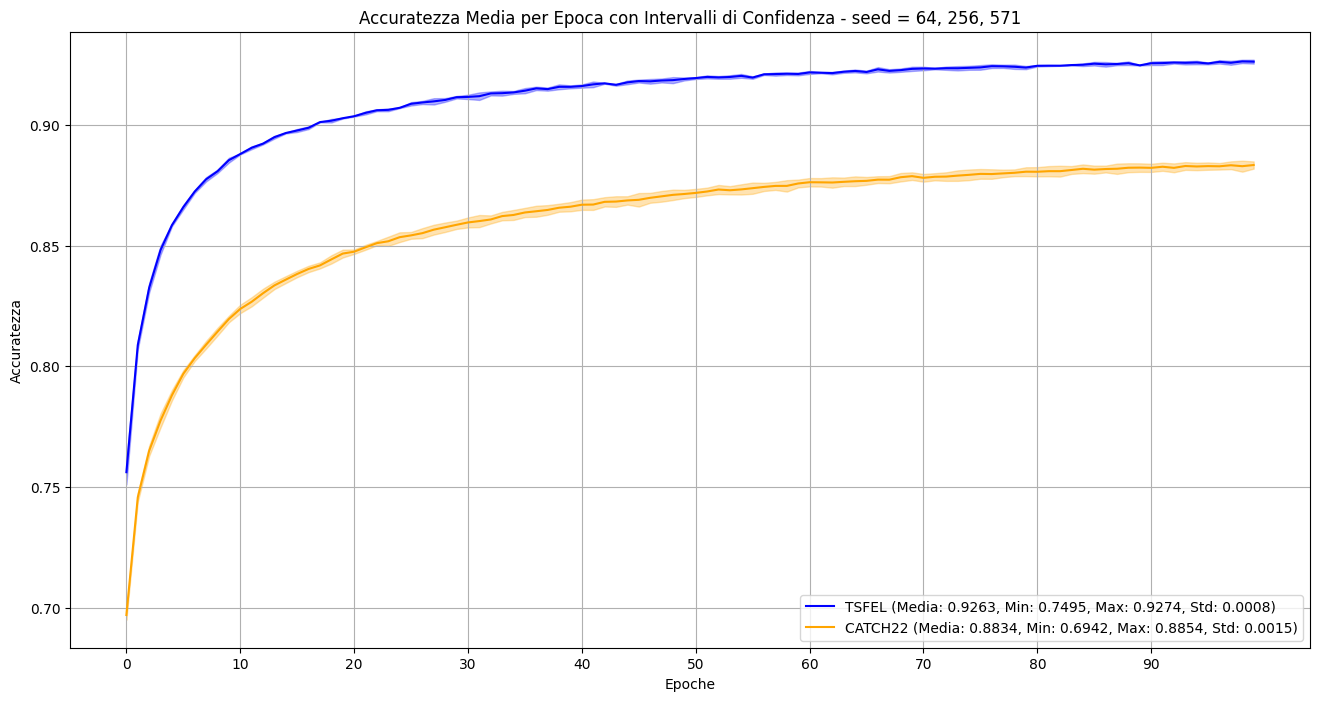

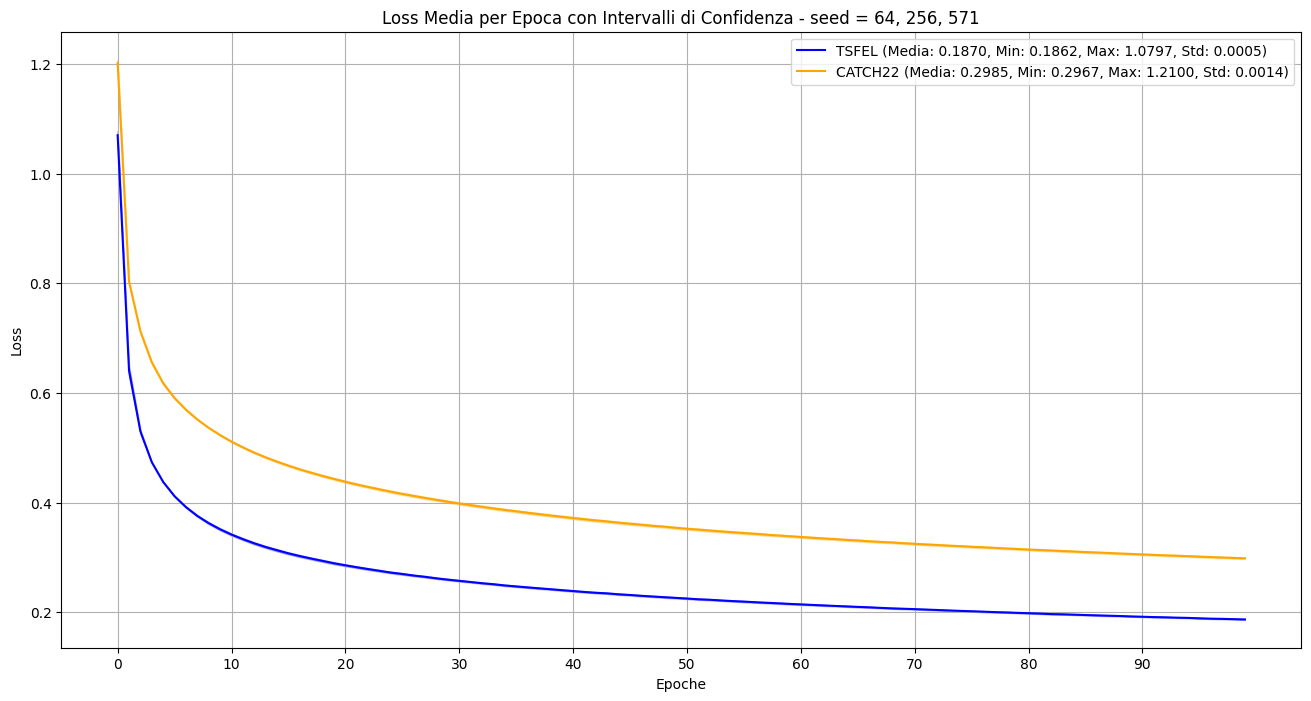

In [ ]:
plot_results(acc_tsfel, acc_catch22, loss_tsfel, loss_catch22, n_epoche)

In [10]:
n_epoche = 100
seeds = [64, 256, 571]
batch_size = 1024
criterion = nn.CrossEntropyLoss()
lr = 1e-4

acc_tsfel = []
acc_catch22 = []

loss_tsfel = []
loss_catch22 = []

execution_tsfel_times = []
execution_catch22_times = []

for seed in seeds:
    # adesso con le cnn
    print(f"Seed: {seed}")
    model_tsfel = SimpleCNN(input_channels=1, sequence_length=tsfel.shape[1], num_classes=6)
    model_catch22 = SimpleCNN(input_channels=1, sequence_length=catch22.shape[1], num_classes=6)

    train_loader_tsfel, val_loader_tsfel = loaders_maker(tsfel.reshape(tsfel.shape[0], 1, tsfel.shape[1]), y, batch_size, seed)
    optimizer = optim.Adam(model_tsfel.parameters(), lr=lr)
    startT = time.time()
    acc_vec_tsfel, loss_vec_tsfel = train_model(model_tsfel.to(device), train_loader_tsfel, val_loader_tsfel, criterion, optimizer, n_epoche)
    
    execution_tsfel_times.append(time.time() - startT)
    acc_tsfel.append(acc_vec_tsfel)
    loss_tsfel.append(loss_vec_tsfel)
    
    train_loader_catch22, val_loader_catch22 = loaders_maker(catch22.reshape(catch22.shape[0], 1, catch22.shape[1]), y, batch_size, seed)
    optimizer = optim.Adam(model_catch22.parameters(), lr=lr)
    startT = time.time()
    acc_vec_catch22, loss_vec_catch22 = train_model(model_catch22.to(device), train_loader_catch22, val_loader_catch22, criterion, optimizer, n_epoche)
    
    execution_catch22_times.append(time.time() - startT)
    acc_catch22.append(acc_vec_catch22)
    loss_catch22.append(loss_vec_catch22)


Seed: 64


Training epochs..: 100%|██████████| 100/100 [16:43<00:00, 10.04s/it]


Tempo totale di addestramento: 1003.91 secondi
Tempo di valutazione (predizioni): 1.10 secondi

Accuratezza finale: 0.9296
Accuratezza media: 0.9169
Accuratezza minima: 0.8183, epoca: 1
Accuratezza massima: 0.9327, epoca: 99
Loss finale: 0.1428, epoca: 1
Loss media: 0.2201
Loss minima: 0.1428, epoca: 100
Loss massima: 0.7597, epoca: 1



Training epochs..: 100%|██████████| 100/100 [10:06<00:00,  6.07s/it]


Tempo totale di addestramento: 606.91 secondi
Tempo di valutazione (predizioni): 0.94 secondi

Accuratezza finale: 0.8951
Accuratezza media: 0.8755
Accuratezza minima: 0.7554, epoca: 1
Accuratezza massima: 0.8951, epoca: 100
Loss finale: 0.2355, epoca: 1
Loss media: 0.3304
Loss minima: 0.2355, epoca: 100
Loss massima: 0.9174, epoca: 1

Seed: 256


Training epochs..: 100%|██████████| 100/100 [13:57<00:00,  8.38s/it]


Tempo totale di addestramento: 837.72 secondi
Tempo di valutazione (predizioni): 1.17 secondi

Accuratezza finale: 0.9356
Accuratezza media: 0.9210
Accuratezza minima: 0.8213, epoca: 1
Accuratezza massima: 0.9359, epoca: 99
Loss finale: 0.1375, epoca: 1
Loss media: 0.2141
Loss minima: 0.1371, epoca: 99
Loss massima: 0.7449, epoca: 1



Training epochs..: 100%|██████████| 100/100 [10:51<00:00,  6.52s/it]


Tempo totale di addestramento: 651.87 secondi
Tempo di valutazione (predizioni): 0.88 secondi

Accuratezza finale: 0.8942
Accuratezza media: 0.8776
Accuratezza minima: 0.7530, epoca: 1
Accuratezza massima: 0.8972, epoca: 89
Loss finale: 0.2355, epoca: 1
Loss media: 0.3299
Loss minima: 0.2355, epoca: 99
Loss massima: 0.9221, epoca: 1

Seed: 571


Training epochs..: 100%|██████████| 100/100 [15:07<00:00,  9.07s/it]


Tempo totale di addestramento: 907.14 secondi
Tempo di valutazione (predizioni): 0.99 secondi

Accuratezza finale: 0.9323
Accuratezza media: 0.9170
Accuratezza minima: 0.8197, epoca: 1
Accuratezza massima: 0.9323, epoca: 100
Loss finale: 0.1447, epoca: 1
Loss media: 0.2224
Loss minima: 0.1447, epoca: 100
Loss massima: 0.7659, epoca: 1



Training epochs..: 100%|██████████| 100/100 [09:35<00:00,  5.76s/it]


Tempo totale di addestramento: 575.51 secondi
Tempo di valutazione (predizioni): 0.92 secondi

Accuratezza finale: 0.8959
Accuratezza media: 0.8769
Accuratezza minima: 0.7560, epoca: 1
Accuratezza massima: 0.8959, epoca: 100
Loss finale: 0.2310, epoca: 1
Loss media: 0.3252
Loss minima: 0.2310, epoca: 100
Loss massima: 0.9158, epoca: 1



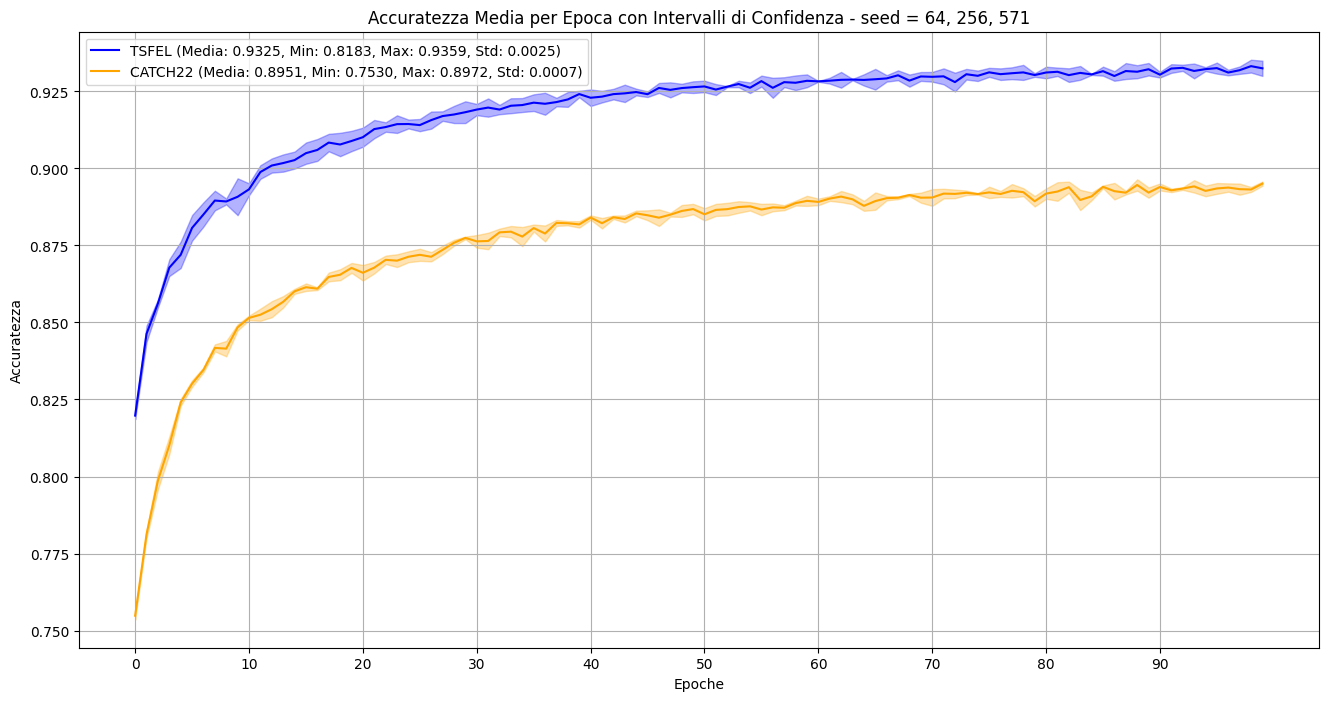

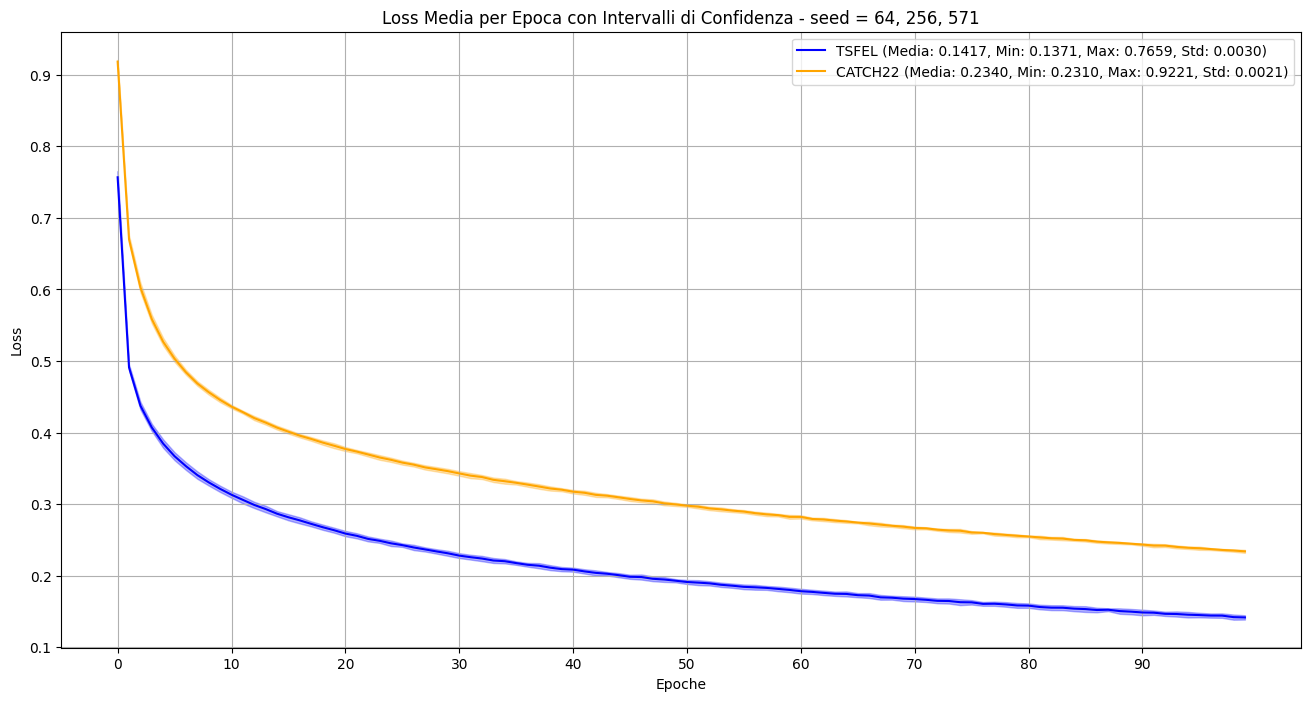

In [11]:
plot_results(acc_tsfel, acc_catch22, loss_tsfel, loss_catch22, n_epoche)

In [ ]:
# Prova con CNN 2d : trattare rappresentazione tsfel e catch22 come immagini

catch22_3d = np.load('catch22_3d_uni.npy')
tsfel_3d = np.load('tsfel_3d_uni.npy')
y_3d = np.load('labels_3d_uni.npy')

print(f"Shape catch22_3d: {catch22_3d.shape}")
print(f"Shape tsfel_3d: {tsfel_3d.shape}")
print(f"Shape labels_3d: {y_3d.shape}")

Shape catch22_3d: (58912, 6, 22)
Shape tsfel_3d: (58912, 6, 45)
Shape labels_3d: (58912,)


In [ ]:
class SimpleCNN2D(nn.Module):
    def __init__(self, channels, features, num_classes):
        super(SimpleCNN2D, self).__init__()

        # Convoluzioni
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3, padding=1)     # (N, 8, H, W)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, padding=1)    # (N, 16, H, W)
        self.pool = nn.MaxPool2d(2, 2)                             # (N, 16, H/2, W/2)

        # Calcola la dimensione dell'output dopo convoluzioni e pooling
        c_out = channels // 2
        f_out = features // 2
        self.flattened_size = 16 * c_out * f_out  # 16 è il numero di canali dopo conv2

        # Fully connected
        self.fc1 = nn.Linear(self.flattened_size, 64)
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))  # (N, 8, H, W)
        x = F.relu(self.conv2(x))  # (N, 16, H, W)
        x = self.pool(x)           # (N, 16, H/2, W/2)
        x = x.view(x.size(0), -1)  # Flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
# Reshaping per CNN 2D

catch22_3d = np.expand_dims(catch22_3d, axis=1)
tsfel_3d = np.expand_dims(tsfel_3d, axis=1)

print(f"Shape catch22_3d reshaped: {catch22_3d.shape}")
print(f"Shape tsfel_3d reshaped: {tsfel_3d.shape}")

Shape catch22_3d reshaped: (58912, 1, 6, 22)
Shape tsfel_3d reshaped: (58912, 1, 6, 45)


In [28]:
n_epoche = 100
seeds = [64, 256, 571]
batch_size = 1024
criterion = nn.CrossEntropyLoss()
lr = 1e-4

acc_tsfel = []
acc_catch22 = []

loss_tsfel = []
loss_catch22 = []

execution_tsfel_times = []
execution_catch22_times = []

for seed in seeds:
    print(f"Seed: {seed}")
    
    model_tsfel = SimpleCNN2D(channels=tsfel_3d.shape[1], features=tsfel_3d.shape[2], num_classes=6)
    model_catch22 = SimpleCNN2D(channels=catch22_3d.shape[1], features=catch22_3d.shape[2], num_classes=6)

    train_loader_tsfel, val_loader_tsfel = loaders_maker(tsfel_3d, y_3d, batch_size, seed)
    optimizer = optim.Adam(model_tsfel.parameters(), lr=lr)

    startT = time.time()
    acc_vec_tsfel, loss_vec_tsfel = train_model(model_tsfel.to(device), train_loader_tsfel, val_loader_tsfel, criterion, optimizer, n_epoche)
    execution_tsfel_times.append(time.time() - startT)

    acc_tsfel.append(acc_vec_tsfel)
    loss_tsfel.append(loss_vec_tsfel)

    train_loader_catch22, val_loader_catch22 = loaders_maker(catch22_3d, y_3d, batch_size, seed)
    optimizer = optim.Adam(model_catch22.parameters(), lr=lr)

    startT = time.time()
    acc_vec_catch22, loss_vec_catch22 = train_model(model_catch22.to(device), train_loader_catch22, val_loader_catch22, criterion, optimizer, n_epoche)
    execution_catch22_times.append(time.time() - startT)
    
    acc_catch22.append(acc_vec_catch22)
    loss_catch22.append(loss_vec_catch22)

Seed: 64


RuntimeError: Given input size: (16x1x6). Calculated output size: (16x0x3). Output size is too small

In [ ]:
plot_results(acc_tsfel, acc_catch22, loss_tsfel, loss_catch22, n_epoche)